In [431]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib ipympl

In [432]:
# Read the CSV files
# ft_sensor_data = pd.read_csv('8_ft_sensor_data_20251030_235747.csv')
# psoc_data = pd.read_csv('8_20251030_235512_test8_actually_tocuhing_properly_plz_red_data.csv')

ft_sensor_data = pd.read_csv('9_ft_sensor_data_20251031_000832.csv')
psoc_data = pd.read_csv('9_20251031_000641_test9_blue_but_touching_properly_data.csv')



# Display basic information about the datasets
print("FT Sensor Data Info:")
print(ft_sensor_data.info())
print("\nFirst few rows of FT Sensor Data:")
print(ft_sensor_data.head())

# print("\nPSOC Data Info:")
# print(psoc_data.info())
# print("\nFirst few rows of PSOC Data:")
# print(psoc_data.head())
psoc_data

FT Sensor Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94900 entries, 0 to 94899
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  94900 non-null  float64
 1   fx         94900 non-null  float64
 2   fy         94900 non-null  float64
 3   fz         94900 non-null  float64
 4   tx         94900 non-null  float64
 5   ty         94900 non-null  float64
 6   tz         94900 non-null  float64
dtypes: float64(7)
memory usage: 5.1 MB
None

First few rows of FT Sensor Data:
   timestamp        fx        fy        fz        tx        ty        tz
0  53.861434 -0.000296  0.027433  0.085557  0.001134  0.001072 -0.000449
1  53.862434 -0.027260 -0.025112 -0.116237  0.000819  0.001002 -0.000126
2  53.863434 -0.035484  0.019288 -0.064295  0.001194  0.001075 -0.000110
3  53.864434  0.001397  0.019746  0.033745  0.000735  0.000480 -0.000077
4  53.865434  0.001246 -0.000344  0.033902  0.000556  0.000491 -0.

,Value,Mode,Port,Timestamp Sent,Timestamp Received
0,108.0,1.0,0.0,25820.0,1.761887e+12
1,15.0,1.0,1.0,28382.0,1.761887e+12
2,15.0,1.0,2.0,28303.0,1.761887e+12
3,15.0,1.0,3.0,27692.0,1.761887e+12
4,14.0,1.0,4.0,28046.0,1.761887e+12
...,...,...,...,...,...
34443,15.0,1.0,3.0,27704.0,1.761887e+12
34444,15.0,1.0,4.0,28066.0,1.761887e+12
34445,15.0,1.0,5.0,28024.0,1.761887e+12
34446,14.0,1.0,6.0,28344.0,1.761887e+12


In [433]:
###################### pre-process PSOC data: ######################

#### fix the timestamps #############

# Identify the first column (assumed to be timestamps)
col0 = psoc_data.columns[0]

# Ensure numeric dtype
psoc_data[col0] = pd.to_numeric(psoc_data[col0], errors='coerce')

# Add 10000 to each negative element in the first column
psoc_data.loc[psoc_data[col0] < 0, col0] += 10000

# Accumulate the column in an "accumulation-esque" fashion (running sum)
psoc_data[col0] = psoc_data[col0].cumsum() / 10000 # 10 khz clock

##### Creating new Super Array #########

# Create an n x 17 array: column 0 = timestamp, columns 1-16 = channels (8*mode + pin)
n = len(psoc_data)
psoc_matrix = np.full((n, 17), np.nan, dtype=float)

# Fill timestamp column (already processed above)
psoc_matrix[:, 0] = psoc_data[col0].values 

# Assume the incoming columns are in positions 1 (mode), 2 (pin), 3 (value)
mode_col = psoc_data.columns[1]
pin_col = psoc_data.columns[2]
val_col  = psoc_data.columns[3]

# Convert to numeric arrays
modes = pd.to_numeric(psoc_data[mode_col], errors='coerce').to_numpy(dtype=float)
pins  = pd.to_numeric(psoc_data[pin_col],  errors='coerce').to_numpy(dtype=float)
vals  = pd.to_numeric(psoc_data[val_col],  errors='coerce').to_numpy(dtype=float)

# Compute channel indices and guard against invalid entries
indices = 8 * modes + pins  # expected range: 0..15
valid = np.isfinite(indices) & (indices >= 0) & (indices < 16) & np.isfinite(vals)

rows = np.nonzero(valid)[0]
cols = indices[valid].astype(int) + 1  # +1 because column 0 is timestamp

# Populate matrix
psoc_matrix[rows, cols] = vals[valid]


# #### interpolation ##########

# Use pandas interpolate() column-wise (treat exact zeros as missing)
col_names = ['timestamp'] + [f'ch{i}' for i in range(1, 17)]
df_psoc = pd.DataFrame(psoc_matrix, columns=col_names)

# Treat exact 0.0 as missing for sensor columns (do not touch timestamp)
sensor_cols = col_names[1:]
df_psoc[sensor_cols] = df_psoc[sensor_cols].replace(0.0, np.nan)

# Interpolate column-wise. 'linear' uses row order; limit_area='inside' avoids extrapolation.
df_psoc.interpolate(method='linear', axis=0, limit_area='inside', inplace=True)

# Replace any remaining NaNs with 0.0 to keep the matrix numeric
df_psoc.fillna(0.0, inplace=True)



##### gets rid of first and last 16 samples #########
df_psoc = df_psoc.iloc[16:-16].reset_index(drop=True)
psoc_data = df_psoc.copy()
print(df_psoc.head(10))


   timestamp         ch1      ch2         ch3      ch4      ch5         ch6  \
0     0.0532  25820.5000  28382.0  28302.6250  27692.0  28047.0  28000.8125   
1     0.0547  25820.5625  28382.0  28302.5625  27692.0  28047.0  28000.7500   
2     0.0562  25820.6250  28382.0  28302.5000  27692.0  28047.0  28000.6875   
3     0.0577  25820.6875  28382.0  28302.4375  27692.0  28047.0  28000.6250   
4     0.0591  25820.7500  28382.0  28302.3750  27692.0  28047.0  28000.5625   
5     0.0606  25820.8125  28382.0  28302.3125  27692.0  28047.0  28000.5000   
6     0.0621  25820.8750  28382.0  28302.2500  27692.0  28047.0  28000.4375   
7     0.0635  25820.9375  28382.0  28302.1875  27692.0  28047.0  28000.3750   
8     0.0744  25821.0000  28382.0  28302.1250  27692.0  28047.0  28000.3125   
9     0.0759  25821.0625  28382.0  28302.0625  27692.0  28047.0  28000.2500   

          ch7      ch8         ch9        ch10     ch11     ch12       ch13  \
0  28276.8750  27997.0  25821.0000  28382.0000  283

In [434]:

# Normalize timestamps by making them relative to start time
ft_start_time = ft_sensor_data['timestamp'].iloc[0]

# use the processed PSOC dataframe (df_psoc) which contains 'timestamp'

psoc_start_time = psoc_data['timestamp'].iloc[0]

# Modify the timestamp columns in place
ft_sensor_data['timestamp'] = ft_sensor_data['timestamp'] - ft_start_time
psoc_data['timestamp'] = (psoc_data['timestamp'] - psoc_start_time) + 1.2 # Add offset
#34.3



In [435]:
# Negate all force and torque measurements from FT sensor
force_torque_columns = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']
ft_sensor_data[force_torque_columns] = ft_sensor_data[force_torque_columns]

In [436]:
# Calculate durations
ft_duration = ft_sensor_data['timestamp'].iloc[-1] - ft_sensor_data['timestamp'].iloc[0]

# Calculate time step in PSOC data
psoc_duration = psoc_data['timestamp'].iloc[-1] - psoc_data['timestamp'].iloc[0]

print(f"FT Sensor Data duration: {ft_duration:.2f} seconds")
print(f"PSOC Data duration: {psoc_duration:.6f} seconds")
print(f"\nNumber of samples:")
print(f"FT Sensor Data: {len(ft_sensor_data)} samples")
print(f"PSOC Data: {len(psoc_data)} samples")


FT Sensor Data duration: 94.96 seconds
PSOC Data duration: 91.177100 seconds

Number of samples:
FT Sensor Data: 94900 samples
PSOC Data: 34416 samples


/tmp/nix-shell.BuT1HZ/ipykernel_11572/2172799827.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent label overlap


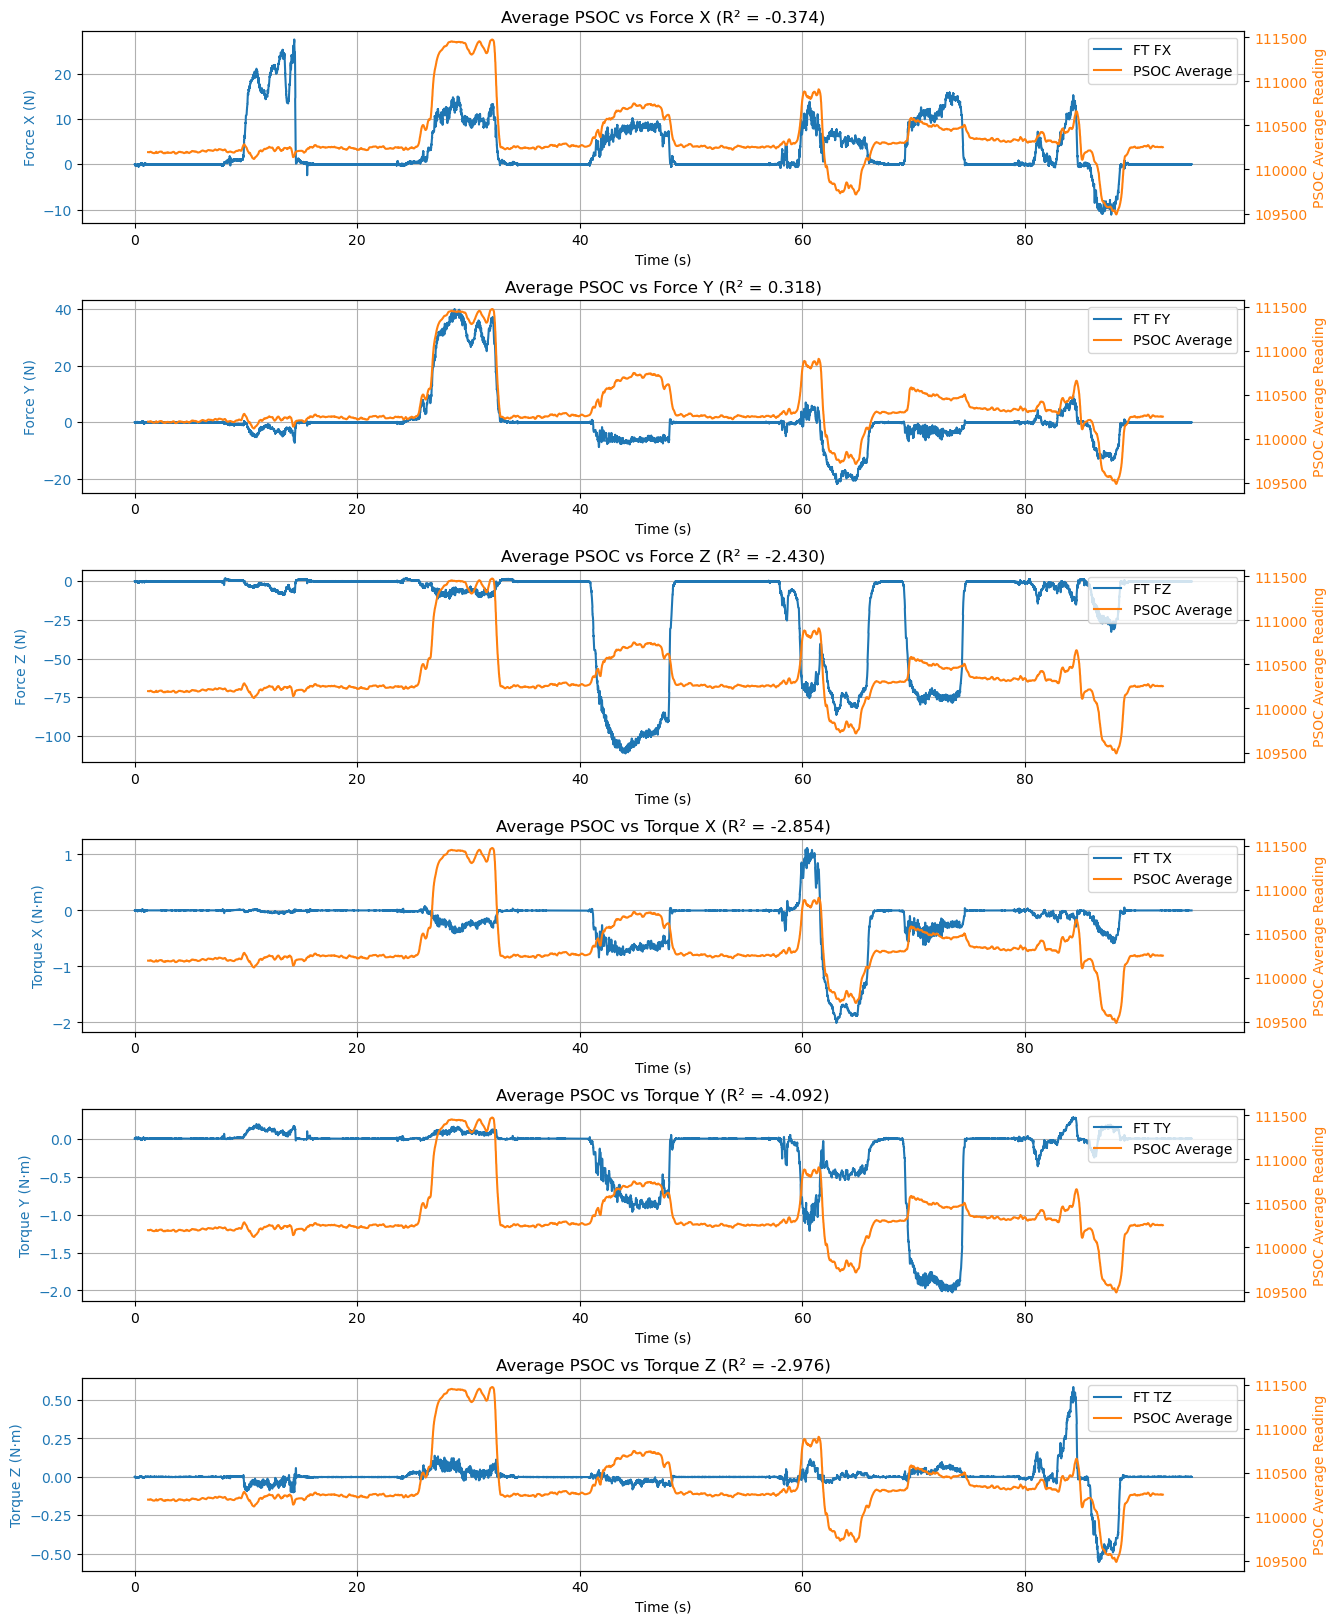

In [437]:
# Calculate average of c1normal through c4normal
avg_normal = psoc_data['ch1'] + psoc_data['ch2'] +psoc_data['ch3'] + psoc_data['ch4']

# Function to calculate R-squared
def calculate_r2(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Create figure with subplots for each force/torque measurement
fig = plt.figure(figsize=(15, 20))
gs = fig.add_gridspec(6, 1, hspace=0.4)

# Plot titles and data to plot
plot_data = [
    ('Average PSOC vs Force X', 'fx', 'Force X (N)'),
    ('Average PSOC vs Force Y', 'fy', 'Force Y (N)'),
    ('Average PSOC vs Force Z', 'fz', 'Force Z (N)'),
    ('Average PSOC vs Torque X', 'tx', 'Torque X (N⋅m)'),
    ('Average PSOC vs Torque Y', 'ty', 'Torque Y (N⋅m)'),
    ('Average PSOC vs Torque Z', 'tz', 'Torque Z (N⋅m)')
]

# Create each subplot
for idx, (title, ft_col, ylabel) in enumerate(plot_data):
    ax1 = fig.add_subplot(gs[idx])
    
    # Plot FT sensor data
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(ylabel, color='tab:blue')
    line1 = ax1.plot(ft_sensor_data['timestamp'], ft_sensor_data[ft_col], 
                     color='tab:blue', label=f'FT {ft_col.upper()}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create second y-axis and plot PSOC data
    ax2 = ax1.twinx()
    ax2.set_ylabel('PSOC Average Reading', color='tab:orange')
    
    line2 = ax2.plot(psoc_data['timestamp'], avg_normal, 
                     color='tab:orange', label='PSOC Average')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Calculate R-squared
    # First interpolate FT sensor data to match PSOC timestamps
    ft_interp = np.interp(psoc_data['timestamp'], 
                         ft_sensor_data['timestamp'], 
                         ft_sensor_data[ft_col])
    
    # Scale both signals to 0-1 range for fair R-squared comparison
    ft_scaled = (ft_interp - ft_interp.min()) / (ft_interp.max() - ft_interp.min())
    psoc_scaled = (avg_normal - avg_normal.min()) / \
                 (avg_normal.max() - avg_normal.min())
    
    r2 = calculate_r2(ft_scaled, psoc_scaled)
    
    # Add title with R-squared and combine legends
    ax1.set_title(f"{title} (R² = {r2:.3f})")
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.grid(True)
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()  # Adjust layout to prevent label overlap

In [438]:
# Map PSOC data to FT sensor data (6 outputs) by finding closest timestamps
# PSOC inputs: all sensor columns except timestamp
# FT outputs: fx, fy, fz, tx, ty, tz

# For each PSOC timestamp, find the closest FT sensor timestamp
from scipy.spatial import KDTree

# Create a KDTree for efficient nearest neighbor search
ft_timestamps = ft_sensor_data['timestamp'].values.reshape(-1, 1)
psoc_timestamps = psoc_data['timestamp'].values.reshape(-1, 1)

tree = KDTree(ft_timestamps)
distances, indices = tree.query(psoc_timestamps)

# Create aligned dataset
# Extract all PSOC input features except timestamp
X = psoc_data.drop('timestamp', axis=1).values

# Extract the corresponding 6 FT sensor outputs using the matched indices
y = ft_sensor_data.iloc[indices][['fx', 'fy', 'fz', 'tx', 'ty', 'tz']].values

print(f"Created aligned dataset:")
print(f"Input features (PSOC): {X.shape} - {X.shape[1]} sensors x {X.shape[0]} samples")
print(f"Output targets (FT): {y.shape} - 6 measurements x {y.shape[0]} samples")
print(f"\nAverage time difference between matched points: {distances.mean()*1000:.3f} ms")
print(f"Max time difference: {distances.max()*1000:.3f} ms")

# Create a DataFrame for easier viewing
aligned_data = pd.DataFrame(X, columns=psoc_data.drop('timestamp', axis=1).columns)
aligned_data[['fx', 'fy', 'fz', 'tx', 'ty', 'tz']] = y
aligned_data['timestamp'] = psoc_data['timestamp'].values

print("\nFirst few rows of aligned data:")
print(aligned_data.head())
psoc_data

Created aligned dataset:
Input features (PSOC): (34416, 16) - 16 sensors x 34416 samples
Output targets (FT): (34416, 6) - 6 measurements x 34416 samples

Average time difference between matched points: 2.291 ms
Max time difference: 44.691 ms

First few rows of aligned data:
          ch1      ch2         ch3      ch4      ch5         ch6         ch7  \
0  25820.5000  28382.0  28302.6250  27692.0  28047.0  28000.8125  28276.8750   
1  25820.5625  28382.0  28302.5625  27692.0  28047.0  28000.7500  28276.8125   
2  25820.6250  28382.0  28302.5000  27692.0  28047.0  28000.6875  28276.7500   
3  25820.6875  28382.0  28302.4375  27692.0  28047.0  28000.6250  28276.6875   
4  25820.7500  28382.0  28302.3750  27692.0  28047.0  28000.5625  28276.6250   

       ch8         ch9        ch10  ...        ch14     ch15     ch16  \
0  27997.0  25821.0000  28382.0000  ...  27999.6875  28276.0  27997.0   
1  27997.0  25821.0625  28382.0000  ...  27999.7500  28276.0  27997.0   
2  27997.0  25821.1250  

,timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,1.2000,25820.5000,28382.0,28302.6250,27692.000,28047.0000,28000.8125,28276.8750,27997.0,25821.0000,28382.0000,28303.0000,27692.0,28046.0000,27999.6875,28276.0000,27997.0
1,1.2015,25820.5625,28382.0,28302.5625,27692.000,28047.0000,28000.7500,28276.8125,27997.0,25821.0625,28382.0000,28303.0000,27692.0,28046.0000,27999.7500,28276.0000,27997.0
2,1.2030,25820.6250,28382.0,28302.5000,27692.000,28047.0000,28000.6875,28276.7500,27997.0,25821.1250,28382.0625,28303.0000,27692.0,28046.0000,27999.8125,28276.0000,27997.0
3,1.2045,25820.6875,28382.0,28302.4375,27692.000,28047.0000,28000.6250,28276.6875,27997.0,25821.1875,28382.1250,28303.0000,27692.0,28046.0000,27999.8750,28276.0000,27997.0
4,1.2059,25820.7500,28382.0,28302.3750,27692.000,28047.0000,28000.5625,28276.6250,27997.0,25821.2500,28382.1875,28303.0000,27692.0,28046.0000,27999.9375,28276.0000,27997.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34411,92.3712,25843.3125,28387.0,28318.1250,27704.000,28067.4375,28024.0000,28343.6875,28065.0,25843.8125,28387.7500,28317.9375,27704.0,28067.0000,28024.7500,28343.0000,28065.0
34412,92.3727,25843.2500,28387.0,28318.2500,27704.125,28067.5000,28024.0000,28343.6250,28065.0,25843.7500,28387.6250,28317.8750,27704.0,28067.0000,28024.8750,28343.0000,28065.0
34413,92.3742,25843.1875,28387.0,28318.3750,27704.250,28067.5625,28024.0000,28343.5625,28065.0,25843.6875,28387.5000,28317.8125,27704.0,28066.9375,28025.0000,28343.0000,28065.0
34414,92.3756,25843.1250,28387.0,28318.5000,27704.375,28067.6250,28024.0000,28343.5000,28065.0,25843.6250,28387.3750,28317.7500,27704.0,28066.8750,28024.9375,28343.0000,28065.0


In [439]:
# Second-order polynomial least squares regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features (degree=2 for second order)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features (degree 2): {X_train_poly.shape[1]}")
print(f"  (includes linear terms, quadratic terms, and interaction terms)\n")

# Train a separate linear regression model for each output
models = {} 
output_names = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

print("Training Results:")
print("=" * 70)
for i, output_name in enumerate(output_names):
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train[:, i])
    models[output_name] = model
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    train_r2 = r2_score(y_train[:, i], y_train_pred)
    test_r2 = r2_score(y_test[:, i], y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train[:, i], y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_pred))
    
    print(f"{output_name}:")
    print(f"  Train R² = {train_r2:.4f}, RMSE = {train_rmse:.4f}")
    print(f"  Test  R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}")
    print()


print(f"\nModels trained successfully!")
print(f"Use 'models' list to access individual models for each output.")
print(f"Use 'poly' to transform new PSOC data before prediction.")

Original features: 16
Polynomial features (degree 2): 153
  (includes linear terms, quadratic terms, and interaction terms)

Training Results:
fx:
  Train R² = 0.9467, RMSE = 1.3453
  Test  R² = 0.9437, RMSE = 1.3931

fy:
  Train R² = 0.9853, RMSE = 1.1418
  Test  R² = 0.9839, RMSE = 1.1620

fz:
  Train R² = 0.9724, RMSE = 5.3402
  Test  R² = 0.9688, RMSE = 5.5237

tx:
  Train R² = 0.9368, RMSE = 0.1019
  Test  R² = 0.9236, RMSE = 0.1057

ty:
  Train R² = 0.9565, RMSE = 0.0984
  Test  R² = 0.9498, RMSE = 0.1047

tz:
  Train R² = 0.8382, RMSE = 0.0374
  Test  R² = 0.8377, RMSE = 0.0380


Models trained successfully!
Use 'models' list to access individual models for each output.
Use 'poly' to transform new PSOC data before prediction.


In [440]:
# Save the trained models to a pickle file
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

print("Models saved to models.pkl")

Models saved to models.pkl


In [441]:
import pickle
from sklearn.preprocessing import PolynomialFeatures

with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

# Recreate the polynomial features transformer (since it wasn't saved)
poly = PolynomialFeatures(degree=2, include_bias=True)

test_row = np.array(range(16)) + 55000

# Transform the test row
test_poly = poly.fit_transform([test_row])

# Make predictions on the test row
print("Predictions for test_row:")
for name, model in models.items():
    pred = model.predict(test_poly)[0]
    print(f"{name}: {pred:.4f}")

Predictions for test_row:
fx: -227424.9754
fy: -940405.1366
fz: -3136000.3313
tx: 11384.3295
ty: -44355.5545
tz: -35580.6552
